# Prerequisite

# 🎯 Objective and Key Learnings

## Objective
The goal of this notebook was to **illustrate the Central Limit Theorem (CLT)** and its implications for **Independent Component Analysis (ICA)**:
- Show how different **non-Gaussian distributions** behave when we take sums of independent samples.
- Demonstrate that as the number of variables $k$ increases, the normalized sum becomes **increasingly Gaussian**, regardless of the original distribution.
- Highlight why ICA relies on **non-Gaussianity** to recover independent sources.

---

## Key Learnings

### 1. Central Limit Theorem in Action
- For small $k$, the distribution of sums retains the shape of the original distribution:
  - Uniform → flat
  - Exponential → skewed
  - Laplace → heavy-tailed
  - Bernoulli/Poisson → discrete
- As $k$ increases ($k=50, 100, 1000$), all of these converge to a **Gaussian distribution**.

---

### 2. Mixtures of Independent Sources
- When multiple non-Gaussian sources are mixed together, the resulting distribution becomes **more Gaussian** due to the CLT.
- Mixing **1000 independent non-Gaussian sources** produces a distribution that is **almost indistinguishable from Gaussian**, even for small $k$.

---

### 3. Implications for ICA
- **Gaussianity destroys information** about independence — mixtures tend to look Gaussian, making it impossible to separate sources based on correlation alone.
- ICA works by finding the **least Gaussian directions** in the data.
- This is why ICA assumes that at most **one source can be Gaussian**, while the others must be **non-Gaussian**.

---

✅ **Takeaway**:  
The Central Limit Theorem explains why **non-Gaussianity** is the key criterion for ICA.  
Without non-Gaussian sources, separation of independent components is not possible.


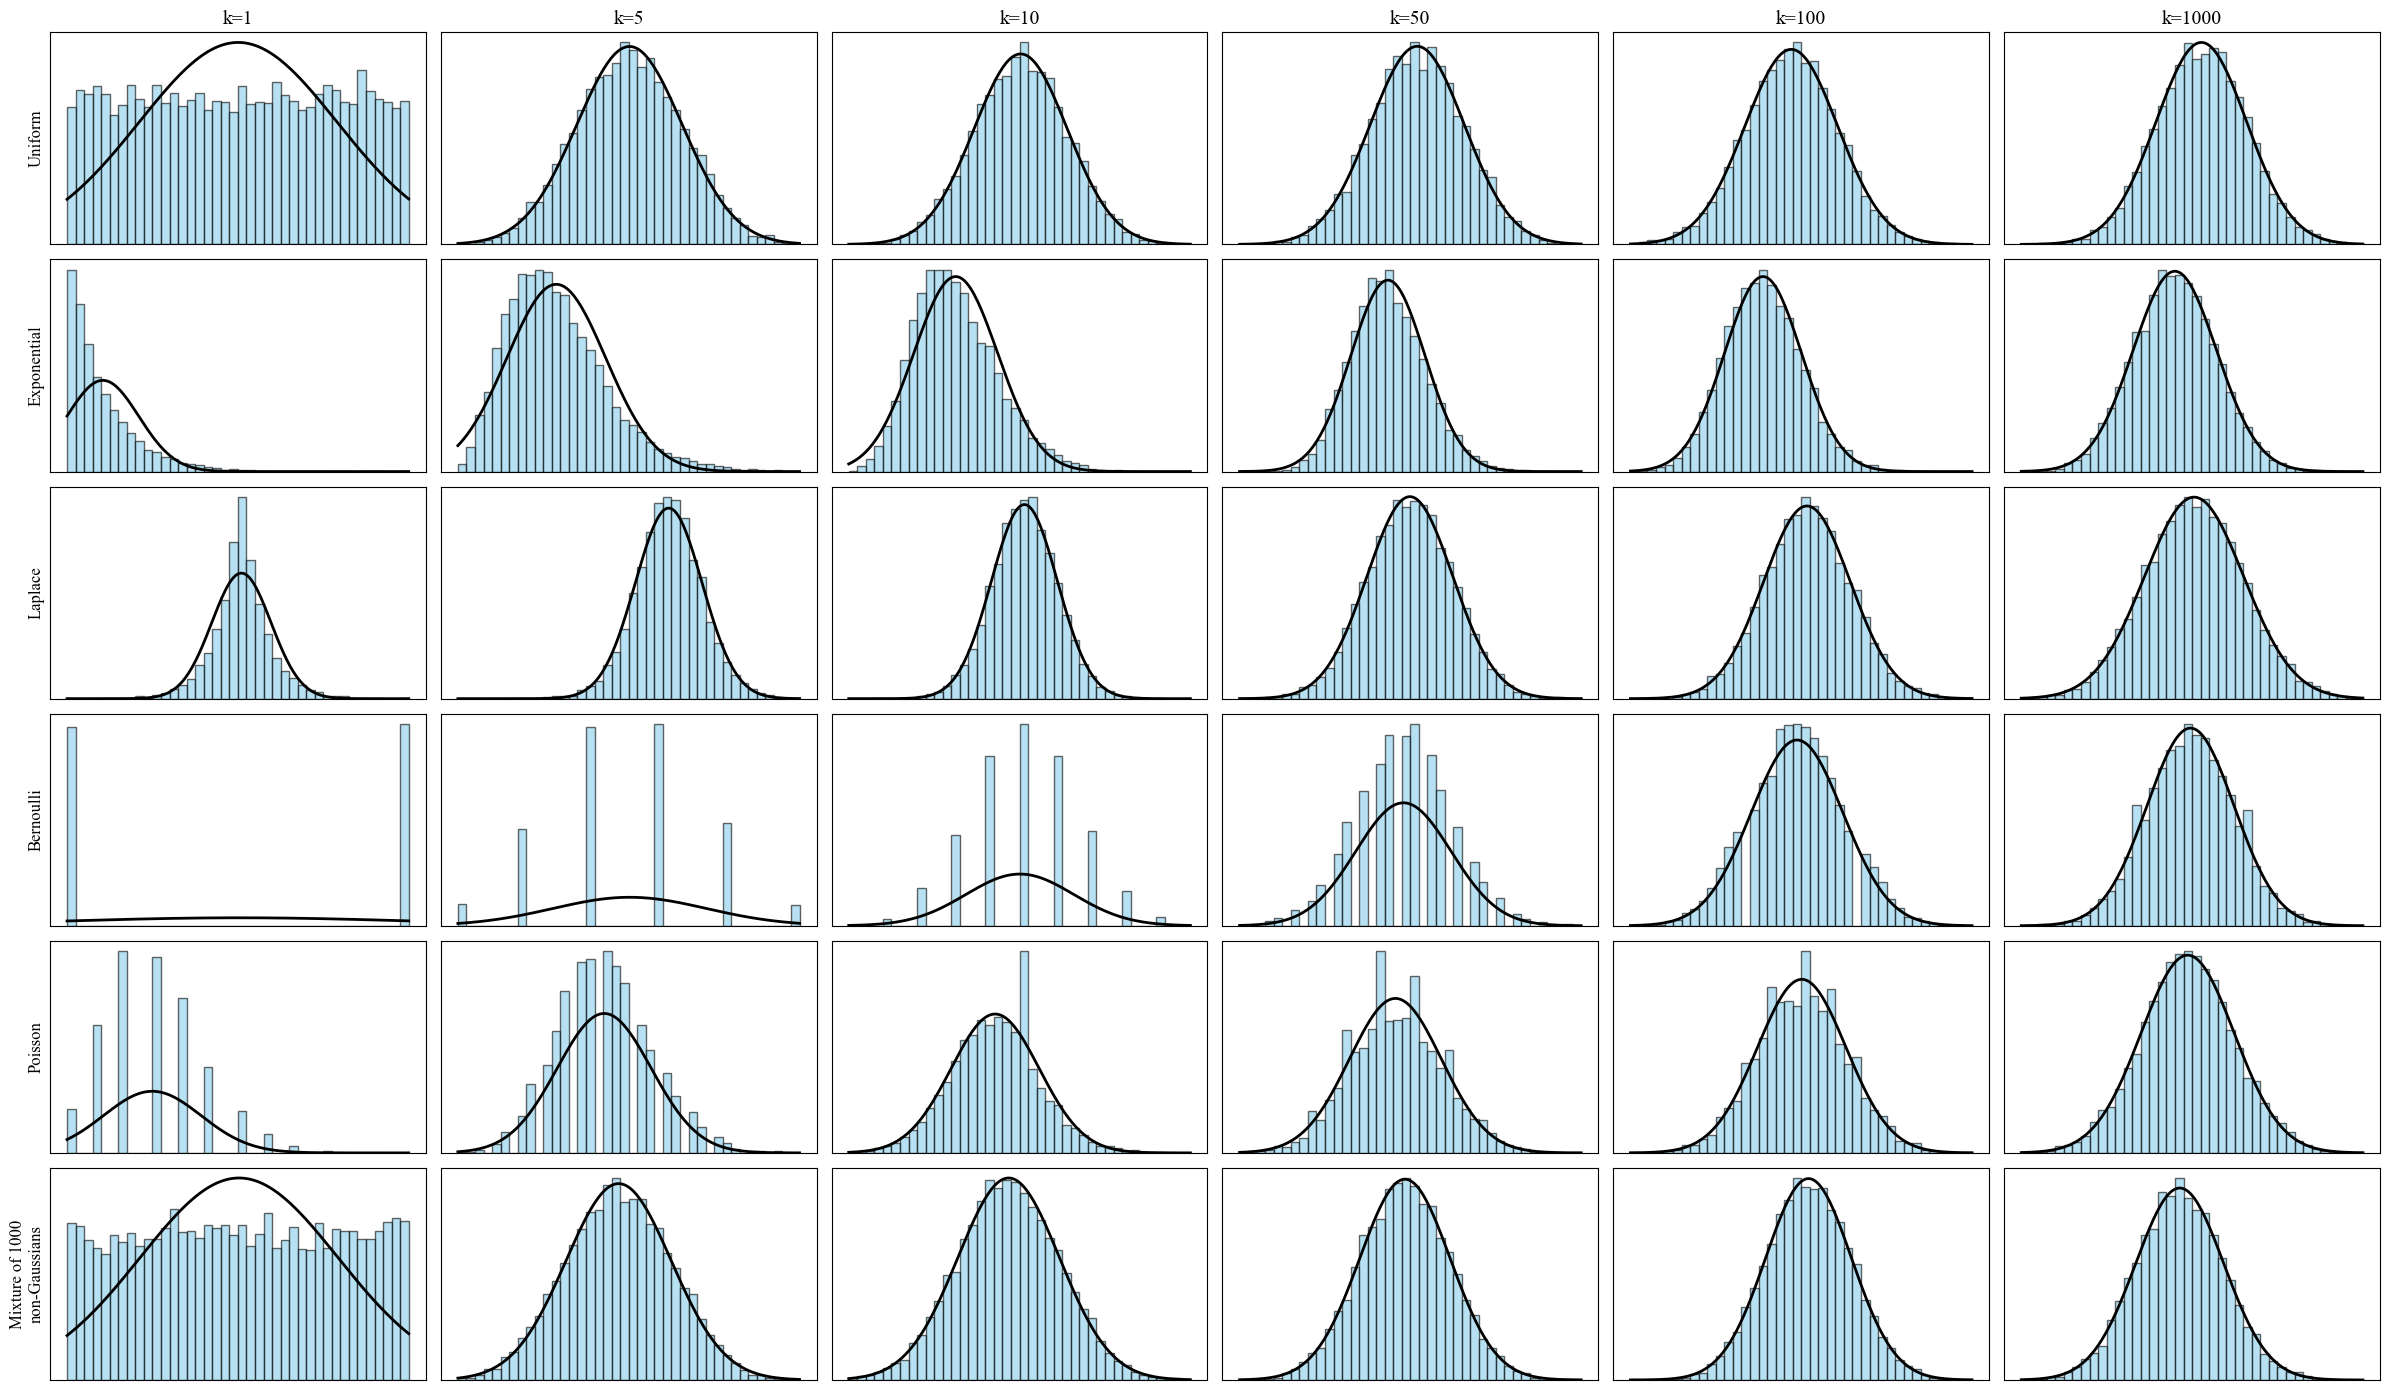

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

plt.rcParams["font.family"] = "Times New Roman"

np.random.seed(42)
n_samples = 10000
k_values = [1, 5, 10, 50, 100, 1000]
distributions = ["uniform", "exponential", "laplace", "bernoulli", "poisson", "mixed1000"]

def generate_data(dist, n_samples, n_vars):
    """Generate i.i.d. samples from different distributions"""
    if dist == "uniform":
        return np.random.uniform(-1, 1, (n_samples, n_vars))
    elif dist == "exponential":
        return np.random.exponential(scale=1.0, size=(n_samples, n_vars))
    elif dist == "laplace":
        return np.random.laplace(0, 1, (n_samples, n_vars))
    elif dist == "bernoulli":
        return np.random.binomial(1, 0.5, (n_samples, n_vars))
    elif dist == "poisson":
        return np.random.poisson(lam=3.0, size=(n_samples, n_vars))
    elif dist == "mixed1000":
        # 1000 different non-Gaussian sources mixed together
        X1 = np.random.uniform(-1, 1, (n_samples, 200))
        X2 = np.random.exponential(1, (n_samples, 200))
        X3 = np.random.laplace(0, 1, (n_samples, 200))
        X4 = np.random.binomial(1, 0.5, (n_samples, 200))
        X5 = np.random.poisson(3, (n_samples, 200))
        X = np.hstack([X1, X2, X3, X4, X5])  # shape: (n_samples, 1000)
        return X
    else:
        raise ValueError("Unknown distribution")

# Create grid
fig, axes = plt.subplots(len(distributions), len(k_values),
                         figsize=(24, 14), sharex=False, sharey=False)

for row, dist in enumerate(distributions):
    X = generate_data(dist, n_samples, max(k_values))
    for col, k in enumerate(k_values):
        ax = axes[row, col]
        sums = X[:, :k].sum(axis=1) / np.sqrt(k)

        # Histogram
        ax.hist(sums, bins=40, density=True, alpha=0.6,
                color="skyblue", edgecolor="black")

        # Gaussian overlay
        mu, sigma = np.mean(sums), np.std(sums)
        x_vals = np.linspace(np.min(sums), np.max(sums), 200)
        ax.plot(x_vals, norm.pdf(x_vals, mu, sigma), 'k', lw=2)

        # Titles/labels
        if row == 0:
            ax.set_title(f"k={k}", fontsize=14)
        if col == 0:
            label = "Mixture of 1000\nnon-Gaussians" if dist=="mixed1000" else dist.capitalize()
            ax.set_ylabel(label, fontsize=12)

        ax.set_xticks([]) 
        ax.set_yticks([])

#plt.suptitle("Central Limit Theorem: Distributions vs. Sample Size", 
#             fontsize=20, fontweight="bold", y=0.93)
plt.tight_layout()

# Save
plt.savefig("ICA-CLT.pdf", bbox_inches="tight")

plt.show()


# Uncorrelated and independence
## Correlation and Mutual Information

# 🎯 Objectives of Examples A–C

## Example A: Correlated Variables
- Show that **linear correlation** captures strong dependence.  
- Example: $Y = 2X + \text{noise}$.  
- Scatter plot: *slanted cloud*.  
- Measures:  
  - Correlation $\rho \approx 1$.  
  - Mutual Information $I(X;Y) > 0$.  
- **Learning:** Correlation is useful when dependence is *linear*.

---

## Example B: Independent Variables
- Show what happens when two variables are **truly independent**.  
- Example: $X \sim \mathcal{N}(0,1), \; Y \sim \text{Laplace}(0,1)$.  
- Scatter plot: *round cloud*.  
- Measures:  
  - Correlation $\rho \approx 0$.  
  - Mutual Information $I(X;Y) \approx 0$.  
- **Learning:** Independence implies zero correlation *and* zero MI.

---

## Example C: Uncorrelated but Dependent
- Show that **zero correlation does not imply independence**.  
- Example: $X \sim \mathcal{U}(-1,1), \; Y = X^2$.  
- Scatter plot: *parabolic shape*.  
- Measures:  
  - Correlation $\rho = 0$.  
  - Mutual Information $I(X;Y) > 0$.  
- **Learning:** Correlation misses nonlinear dependencies; MI captures them.

---

## ✅ Takeaway
- **Correlation**: detects only *linear* dependence.  
- **Independence**: stronger condition — no dependence of any kind.  
- **Mutual Information (MI)**: general measure of dependence.  
- This motivates ICA: it seeks components that minimize **mutual information**, not just correlation.


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import math
from collections import Counter

# ------------------------------
# 1. Functions from scratch
# ------------------------------

def correlation(x, y):
    """Compute Pearson correlation coefficient from scratch."""
    n = len(x)
    mean_x = sum(x) / n
    mean_y = sum(y) / n
    
    num = sum((xi - mean_x) * (yi - mean_y) for xi, yi in zip(x, y))
    den = math.sqrt(sum((xi - mean_x)**2 for xi in x) * sum((yi - mean_y)**2 for yi in y))
    
    return num / den if den != 0 else 0

def mutual_information(x, y, bins=20):
    """Estimate mutual information from scratch using histogram binning."""
    n = len(x)
    
    # Bin the data
    x_bins = np.linspace(min(x), max(x), bins+1)
    y_bins = np.linspace(min(y), max(y), bins+1)
    
    x_digitized = np.digitize(x, x_bins) - 1
    y_digitized = np.digitize(y, y_bins) - 1
    
    # Joint counts
    joint_counts = Counter(zip(x_digitized, y_digitized))
    px = Counter(x_digitized)
    py = Counter(y_digitized)
    
    mi = 0.0
    for (xi, yi), joint_count in joint_counts.items():
        p_xy = joint_count / n
        p_x = px[xi] / n
        p_y = py[yi] / n
        mi += p_xy * math.log(p_xy / (p_x * p_y) + 1e-12, 2)  # base-2 log
    
    return mi



Correlation (from scratch): 0.986
Mutual Information (from scratch): 2.458 bits


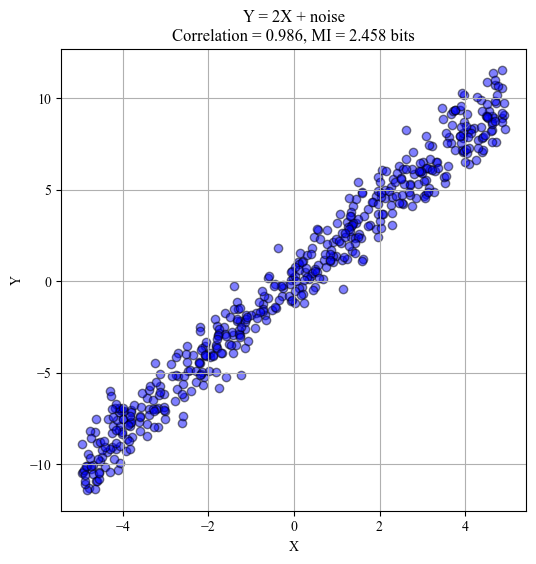

In [8]:
# ------------------------------
# 2. Generate correlated data
# ------------------------------
np.random.seed(42)
n_points = 500
X = np.random.uniform(-5, 5, n_points)
Y = 2 * X + np.random.normal(0, 1, n_points)

# ------------------------------
# 3. Compute correlation + MI
# ------------------------------
rho = correlation(X.tolist(), Y.tolist())
mi = mutual_information(X.tolist(), Y.tolist(), bins=20)

print(f"Correlation (from scratch): {rho:.3f}")
print(f"Mutual Information (from scratch): {mi:.3f} bits")

# ------------------------------
# 4. Plot
# ------------------------------
plt.figure(figsize=(6, 6))
plt.scatter(X, Y, alpha=0.5, color="blue", edgecolor="k")
plt.title(f"Y = 2X + noise\nCorrelation = {rho:.3f}, MI = {mi:.3f} bits")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()


Correlation (from scratch): 0.006
Mutual Information (from scratch): 0.316 bits


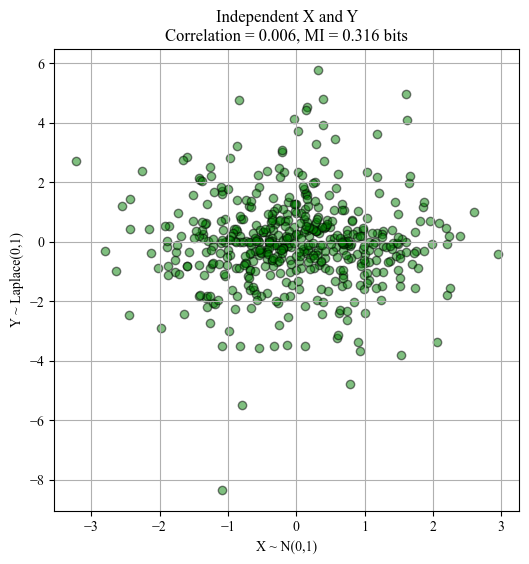

In [9]:
# ------------------------------
# Generate independent data
# ------------------------------
np.random.seed(123)
n_points = 500
X = np.random.normal(0, 1, n_points)          # Gaussian
Y = np.random.laplace(0, 1, n_points)         # Laplace
# Independent because generated separately

# ------------------------------
# Compute correlation + MI
# ------------------------------
rho = correlation(X.tolist(), Y.tolist())
mi = mutual_information(X.tolist(), Y.tolist(), bins=20)

print(f"Correlation (from scratch): {rho:.3f}")
print(f"Mutual Information (from scratch): {mi:.3f} bits")

# ------------------------------
# Plot
# ------------------------------
plt.figure(figsize=(6, 6))
plt.scatter(X, Y, alpha=0.5, color="green", edgecolor="k")
plt.title(f"Independent X and Y\nCorrelation = {rho:.3f}, MI = {mi:.3f} bits")
plt.xlabel("X ~ N(0,1)")
plt.ylabel("Y ~ Laplace(0,1)")
plt.grid(True)
plt.show()

Correlation (from scratch): -0.035
Mutual Information (from scratch): 2.848 bits


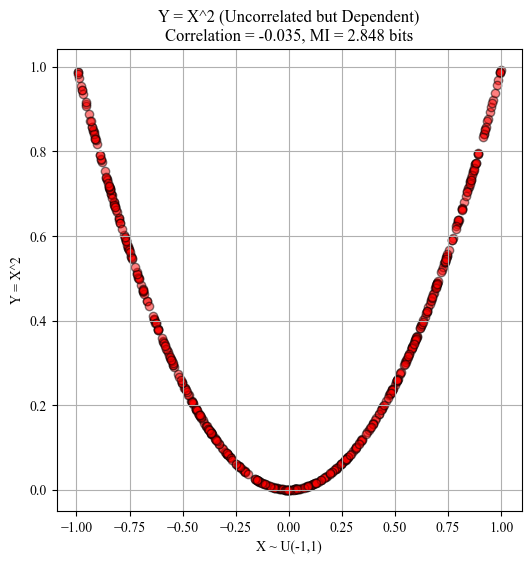

In [10]:
# ------------------------------
# Generate dependent but uncorrelated data
# ------------------------------
np.random.seed(321)
n_points = 500
X = np.random.uniform(-1, 1, n_points)
Y = X**2

# ------------------------------
# Compute correlation + MI
# ------------------------------
rho = correlation(X.tolist(), Y.tolist())
mi = mutual_information(X.tolist(), Y.tolist(), bins=20)

print(f"Correlation (from scratch): {rho:.3f}")
print(f"Mutual Information (from scratch): {mi:.3f} bits")

# ------------------------------
# Plot
# ------------------------------
plt.figure(figsize=(6, 6))
plt.scatter(X, Y, alpha=0.5, color="red", edgecolor="k")
plt.title(f"Y = X^2 (Uncorrelated but Dependent)\nCorrelation = {rho:.3f}, MI = {mi:.3f} bits")
plt.xlabel("X ~ U(-1,1)")
plt.ylabel("Y = X^2")
plt.grid(True)
plt.show()